# Continue channels analysis based on their activity

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# This is just for style to the charts
import seaborn as sns

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=12)          # controls default text sizes

In [13]:
def add_pubkey2(series, channels):
    channels = channels.drop_duplicates(['chan_id'], keep='last')
    channels['chan_id'] = channels['chan_id'].astype(np.int64)
    series = series.reset_index().rename({'index':'outgoing_channel_id',
                                      0:'balanced_metric'}, axis=1)
    series['pubkey'] = ''
    out_chan_ids = series['outgoing_channel_id'].unique()
    
    for i in out_chan_ids:
        
        for z, j in channels[['chan_id', 'pub_key']].iterrows():
            
            if i == j['chan_id']:
                series.loc[series['outgoing_channel_id'] == i, 'pubkey'] = j['pub_key']
                
                break
                
    return series['pubkey']

**In the first notebook we create a dataframe of the peer nodes connected to our channels. Let's bring that dataframe here and continue with the analysis.**

In [4]:
active_routing_nodes = pd.read_csv('active_routing_nodes.csv', index_col=0)

In [6]:
active_routing_nodes.head(2)

,success_rate,alias,balanced_rate,total_Forwards
pubkey,,,,
0203f3e0fdaa52ca5c804d145b6a47e5a620c02123106578230061deb212e720bd,0.002255,0203f3e0fdaa52ca5c80,0.292635,3104.0
0205306aa071fc026a4884c210d99d886f199068a6ccc65ec1bde085f846be3641,0.003647,Magrathea,0.672870,4113.0


## Add total revenue to the analysis

In [11]:
# Open forwards dataset
forwards_path = '../Datos/forwards_2022-06-29.csv'
df_forwards = pd.read_csv(forwards_path)

# changing the type of the channel ids to be displayed correctly
df_forwards[['outgoing_channel_id', 'incoming_channel_id']] = df_forwards[['outgoing_channel_id', 
                                                                           'incoming_channel_id']].astype(np.int64)

In [14]:
# Open channel events dataset
channels_path = '../Datos/channel_events_2022-06-29.csv'
df_channels = pd.read_csv(channels_path)
df_channels['chan_id'] = df_channels['chan_id'].astype(np.int64)

In [12]:
# total revenue
total_revenue_df = df_forwards.groupby('outgoing_channel_id')['fee_msat'].aggregate('sum')

In [16]:
total_revenue = total_revenue_df.copy()
total_revenue = total_revenue.reset_index()
# Add pubkey of the peers the channels are linked to
total_revenue['pubkey'] = add_pubkey2(total_revenue_df, df_channels)

total_revenue.set_index('pubkey', inplace=True)
total_revenue.rename({0:'normalized_revenue'}, axis=1, inplace=True)
total_revenue.head(2)

,outgoing_channel_id,fee_msat
pubkey,,
027578e823ce91a00ef9576d3d24e0a21abfa3332ba186654730a0c8804cbb844b,767907716957798400,212160.0
02b37a7de2b3a6b4b04485a2a6eba03feff0d5d34813a0401d09fbcbfedfbb1a1f,767913214610702336,16814.0


In [24]:
# Drop duplicates
total_revenue = total_revenue.reset_index().sort_values(by='fee_msat').drop_duplicates('pubkey', keep='last').set_index('pubkey')

In [25]:
active_routing_nodes['total_revenue'] = total_revenue['fee_msat']

In [27]:
# active_routing_nodes.head(5)

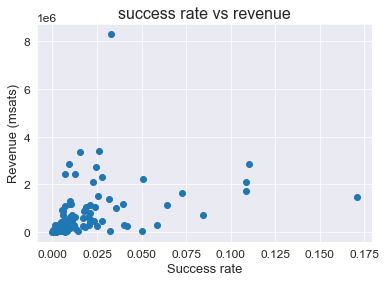

In [29]:
plt.scatter(active_routing_nodes['success_rate'],active_routing_nodes['total_revenue'])
plt.title('success rate vs revenue')
plt.ylabel('Revenue (msats)')
_ = plt.xlabel('Success rate')

We see an increasing patter where if the success rate increases, the revenue does too. It makes total sense, since if a channel forwards more payments successfully, then it will charge more fees.

In [76]:
def compute_corr_mat(df):
    """Creates the correlation matrix"""
    
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    _ = plt.title('Correlation Matrix')
    return corr

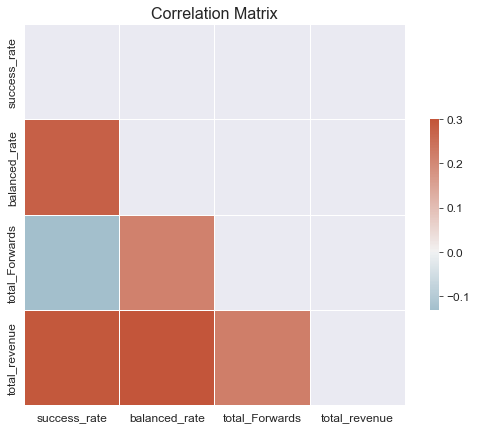

In [49]:
c = compute_corr_mat(active_routing_nodes[['success_rate','balanced_rate','total_Forwards','total_revenue']])

In [50]:
c

,success_rate,balanced_rate,total_Forwards,total_revenue
success_rate,1.000000,0.276779,-0.131584,0.293115
balanced_rate,0.276779,1.000000,0.213419,0.313988
total_Forwards,-0.131584,0.213419,1.000000,0.219504
total_revenue,0.293115,0.313988,0.219504,1.000000


- *Total forwards* and *total revenue* are positively correalted. This makes sense, since the more successful payments forwarded, the more fees you would charge. 
- *Success rate* and *total_revenue* are correlated, just like *balanced rate* and *total revenue*. Remember in the first notebook we stated why when a channel is balanced it might present more traffic. It it does, then it's success rate might increase as well, hence increasing the total revenue. 

Se how everything **connects** with everything.

## Does channels linked to nodes with more channels have more forwardattempts?

**ADD THE TOTAL NUMBER OF CHANNELS A NODE HAS TO THE ANALYSIS**

In [55]:
import json
from pandas import json_normalize

In [63]:
def add_node_chan_info(df_nodes, df_channels):
    df_nodes = pd.concat([
        df_nodes,
        pd.DataFrame(columns=[
                'num_channels',
        ])
    ], sort=False)
    
    for index, node in df_nodes.iterrows():

        pub_key = node['pub_key']
        # obtain those channels that were opened by this specific node
        node1_channels = df_channels[df_channels.node1_pub == pub_key]
        
        # obtain those channels that were opened by other nodes
        node2_channels = df_channels[df_channels.node2_pub == pub_key]

        df_nodes.loc[index, 'num_channels'] = node1_channels.shape[0] + node2_channels.shape[0]

    return df_nodes

In [ ]:
# This is the whole network graph dataset
file_name = '../Datos/graph_metrics_2022-06-29.json'
graph_data = open(file_name, encoding='utf8')
graph_json = json.load(graph_data)
# converting data to pd dfs
nodes_graph = json_normalize(graph_json['nodes'])
channels_graph = json_normalize(graph_json['edges'])
channels_graph.channel_id = channels_graph.capacity.astype(int)
channels_graph.capacity = channels_graph.capacity.astype(int)

In [ ]:
ln_graph = add_node_chan_info(nodes_graph, channels_graph)
# You can comment this cell and the one above when they finish runing.
# This cell takes its time to process.

In [ ]:
# You may comment this cell after running it.
ln_graph.to_csv('ln_graph.csv', encoding='utf-8')

In [56]:
# If the cells above have been run once, then you can comment them and load
# the network graph directly from the dataset saved in the above cell.
ln_graph = pd.read_csv('ln_graph.csv', index_col=0)

In [57]:
# Appending peers number of channels to the analysis
active_routing_nodes['num_channels'] = ln_graph.set_index('pub_key')['num_channels']

In [58]:
active_routing_nodes['num_channels'].isna().sum()
# If there are nan values, it means some nodes in the network are dead already

9

In [59]:
# set nan values to 0
active_routing_nodes['num_channels'].fillna(0, inplace=True)

In [60]:
# Filtering out channels connected to dead nodes.
active_routing_nodes = active_routing_nodes[active_routing_nodes['num_channels'] != 0]

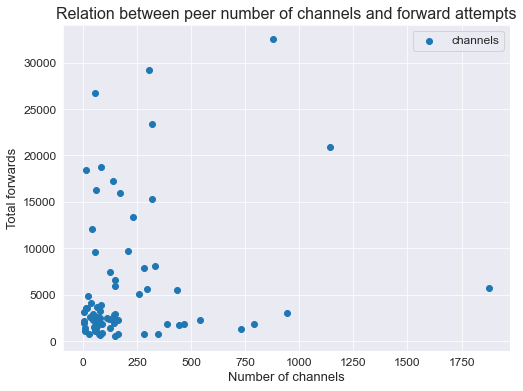

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(active_routing_nodes['num_channels'], active_routing_nodes['total_Forwards'], label='channels')
plt.ylabel('Total forwards')
plt.xlabel('Number of channels')
plt.legend()

_ = plt.title('Relation between peer number of channels and forward attempts')

,success_rate,balanced_rate,total_Forwards,total_revenue,num_channels
success_rate,1.000000,0.251656,-0.147589,0.288645,-0.089388
balanced_rate,0.251656,1.000000,0.199773,0.300264,-0.010831
total_Forwards,-0.147589,0.199773,1.000000,0.185880,0.206207
total_revenue,0.288645,0.300264,0.185880,1.000000,0.118454
num_channels,-0.089388,-0.010831,0.206207,0.118454,1.000000


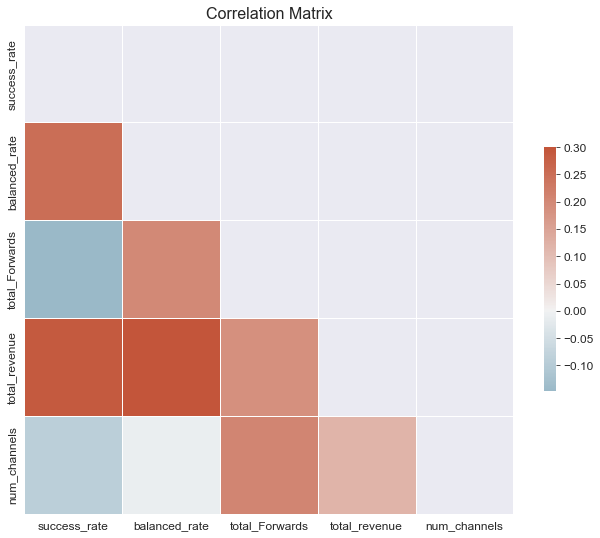

In [78]:
# Compute the correlation matrix
corr = compute_corr_mat(active_routing_nodes[['success_rate','balanced_rate','total_Forwards','total_revenue', 'num_channels']])
corr

In [69]:
import scipy.stats as stats
# compute p value
stats.ttest_ind(a=active_routing_nodes['num_channels'],b=active_routing_nodes['total_Forwards'],equal_var=False)

Ttest_indResult(statistic=-6.788475508446619, pvalue=2.670410890792175e-09)

Based on this data, the answer to our question is yes, channels linked to nodes with more channels have more forward attempts. However, it seems like there's a limit to the number of channels a node has that increases significantly the forward attempts of our channel linked to that node. We saw this in the chart relating these two features, where an increasing pattern breaks after a peer node has 250+ channels.

The correlation matrix confirms there's a weak correlation between these features.

So, if we're looking to increase our node activity, **with who we may create channels?**

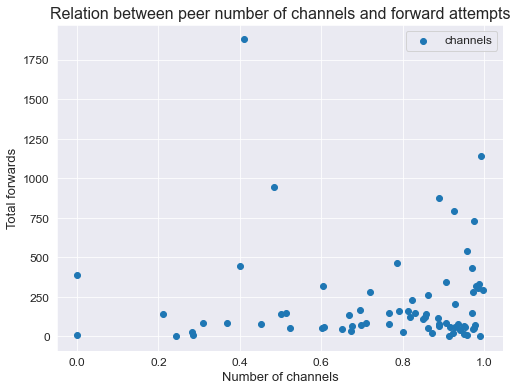

In [83]:
plt.figure(figsize=(8,6))
plt.scatter(active_routing_nodes['balanced_rate'], active_routing_nodes['num_channels'], label='channels')
plt.ylabel('Total forwards')
plt.xlabel('Number of channels')
plt.legend()

_ = plt.title('Relation between peer number of channels and forward attempts')